In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import pymysql
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sqlalchemy import text

In [3]:
#!pip install scikit-learn

In [4]:
#!pip install statsmodels

In [5]:
username = "root"
password = "root%401234" #Here @ replaced with '%40'
host = "localhost"
port = "3306" #Default mysql port
database = "SupplyChainDB"

engine = create_engine(f"mysql+mysqlconnector://{username}:{password}@{host}:{port}/{database}")

with engine.connect() as connection:
    print("Connected to MySQL successfully!")

Connected to MySQL successfully!


In [6]:
with engine.connect() as conn:
    result = conn.execute(text("SELECT * FROM medicines"))
    #for row in result:
     #   print(row)


In [7]:
conn = engine.raw_connection()
cursor = conn.cursor()

# Call the stored procedure with parameters
cursor.callproc("PrescriptionDemandTrendsWeekly", (2, 106, None, 2024))  

for result in cursor.stored_results():
    df = pd.DataFrame(result.fetchall(), columns=[desc[0] for desc in result.description])

cursor.close()
conn.close()
print(df.head(n=10))


   medicine_id SumDemandPrevWeek SumDemandCurrWeek ChangeOverPrevWeek  WeekNum
0          106              None                28               None        0
1          106                28                 8             -71.43        1
2          106                 8                13              62.50        2
3          106                13                12              -7.69        5
4          106                12                12               0.00        9
5          106                12                32             166.67       11
6          106                32                10             -68.75       12


In [8]:
query1 = "select * from medicines;"
medicines_df = pd.read_sql_query(query1, engine)

In [9]:
medicines_df.head()

,medicine_id,name,category,manufacturer,shelf_life,cost_price,selling_price
0,100,Amoxicillin,Blood Pressure,Merck,57,61.49,81.45
1,101,Ibuprofen,Cardiac,Bayer,60,16.07,18.55
2,102,Metformin,Respiratory,Eli Lilly,21,51.96,77.86
3,103,Aspirin,Mental Health,Sanofi,36,73.96,91.44
4,104,Losartan,Digestive,Johnson & Johnson,52,64.37,71.64


In [10]:
medicines_df['profit_margin'] = np.round((medicines_df['selling_price'] - medicines_df['cost_price']) *100 / medicines_df['cost_price'], 2)

In [11]:
query2 = "select * from inventory"
inventory_df = pd.read_sql_query(query2,engine)

In [12]:
inventory_df.head()

,inventory_id,facility_id,medicine_id,cost_price,quantity_in_stock,reorder_level,inventory_value,expiry_date,last_updated
0,1,1,100,61.49,45,0,2767.05,2025-07-15,2025-02-14
1,2,1,101,16.07,42,105,674.94,2027-08-13,2025-02-14
2,3,1,102,51.96,40,69,2078.40,2025-10-18,2025-02-14
3,4,1,103,73.96,38,46,2810.48,2027-05-20,2025-02-14
4,5,1,104,64.37,38,88,2446.06,2026-04-14,2025-02-14


In [13]:
for i in inventory_df.index:
    if inventory_df.loc[i, 'quantity_in_stock'] < inventory_df.loc[i, 'reorder_level']:
        inventory_df.loc[i, 'NeedsRestocking'] = "Yes"
    else:
        inventory_df.loc[i, 'NeedsRestocking'] = "No"

In [14]:
inventory_df.head()

,inventory_id,facility_id,medicine_id,cost_price,quantity_in_stock,reorder_level,inventory_value,expiry_date,last_updated,NeedsRestocking
0,1,1,100,61.49,45,0,2767.05,2025-07-15,2025-02-14,No
1,2,1,101,16.07,42,105,674.94,2027-08-13,2025-02-14,Yes
2,3,1,102,51.96,40,69,2078.40,2025-10-18,2025-02-14,Yes
3,4,1,103,73.96,38,46,2810.48,2027-05-20,2025-02-14,Yes
4,5,1,104,64.37,38,88,2446.06,2026-04-14,2025-02-14,Yes


In [15]:
#inventory_df[inventory_df['NeedsRestocking'] == "Yes"]

In [16]:
#inventory_df[['medicine_id','facility_id']].count()

In [17]:
#inventory_df.isna().sum()

In [18]:
#inventory_df.duplicated().sum()

In [19]:
#inventory_df[(inventory_df['facility_id'] == 1) & (inventory_df['medicine_id'] == 100)]

In [20]:
#inventory_df.groupby('facility_id')['quantity_in_stock'].sum()

In [21]:
#result = inventory_df.groupby('facility_id').agg({
 #   'quantity_in_stock' : 'sum',
  #  'inventory_value': 'sum',
   # 'cost_price': ['min', 'max'] 
#})

In [22]:
#result['cost_price']['max']

In [23]:
query3 = "select * from suppliers;"
suppliers_df = pd.read_sql_query(query3,engine)

In [24]:
suppliers_df

,supplier_id,name,delivery_time_avg,reliability_score
0,200,MediSupply Co.,23,0.41
1,201,Global Pharma Distributors,23,0.49
2,202,HealthBridge Suppliers,23,0.47
3,203,Evergreen Medical Supplies,22,0.54
4,204,Pioneer Drug Distributors,22,0.47
5,205,Elite Pharma Solutions,26,0.52
6,206,WellnessMed Supplies,25,0.44
7,207,Guardian Healthcare Logistics,24,0.56


In [25]:
query4 = "select * from facilities;"
facilities_df = pd.read_sql_query(query4,engine)

In [26]:
facilities_df['type'] = facilities_df['type'].str.replace('\r', '', regex=True)

In [27]:
facilities_df

,facility_id,f_name,type
0,1,HealthFirst Pharmacy,Pharmacy
1,2,MediCare Drugstore,Pharmacy
2,3,Good Neighbor Pharmacy,Pharmacy
3,4,St. Mary's Hospital,Hospital
4,5,Grandview Medical Center,Hospital
5,6,WellSpring Pharmacy,Pharmacy
6,7,Mercy General Hospital,Hospital
7,8,Guardian Rx,Pharmacy
8,9,Riverside Community Hospital,Hospital
9,10,Evercare Hospital,Hospital


In [28]:
#facilities_df[facilities_df['type'] == 'Pharmacy']

In [29]:
query5 = "select * from supply_orders;"
supply_orders_df = pd.read_sql_query(query5,engine)

In [30]:
#supply_orders_df.info()

In [31]:
for col in supply_orders_df.columns:
    if "date" in col:
        supply_orders_df[f"{col}"] = pd.to_datetime(supply_orders_df[f"{col}"])

In [32]:
supply_orders_df.head()

,order_id,supplier_id,medicine_id,facility_id,quantity_ordered,order_date,expected_delivery_date,actual_delivery_date
0,1,207,107,9,14,2024-03-24,2024-03-29,2024-03-31
1,2,205,122,7,14,2024-03-10,2024-03-20,2024-03-20
2,3,202,107,6,12,2024-02-28,2024-03-09,2024-03-11
3,4,202,135,3,10,2024-03-10,2024-03-14,2024-03-13
4,5,206,142,5,13,2024-03-22,2024-03-27,2024-03-27


In [33]:
query6 = "select * from prescription_demand;"
prescription_demand_df = pd.read_sql_query(query6,engine)

In [34]:
#prescription_demand_df.count()

In [35]:
prescription_demand_df.head()

,prescription_id,facility_id,medicine_id,quantity_prescribed,prescription_date,selling_price,revenue,payment_mode,insurance_covered_amount,patient_paid_amount
0,1,9,148,14,2024-03-28,113.53,1589.42,Insurance,1133.13,456.29
1,2,6,141,7,2024-01-29,85.44,598.08,Insurance,388.27,209.81
2,3,6,114,10,2024-02-23,41.84,418.40,Cash,0.00,209.20
3,4,6,123,12,2024-03-15,32.67,392.04,Cash,0.00,163.35
4,5,5,129,7,2024-03-01,48.51,339.57,Insurance,206.18,133.39


In [36]:
query7 = "select * from late_deliveries_results;"
late_deliveries_df = pd.read_sql_query(query7,engine)

In [37]:
late_deliveries_df

,supplier_id,name,LateDeliveries,TotalDeliveries,LateDeliveriesAsPercentageOfTotal,reliability_score
0,200,MediSupply Co.,70,118,59.32,0.41
1,201,Global Pharma Distributors,63,124,50.81,0.49
2,202,HealthBridge Suppliers,67,127,52.76,0.47
3,203,Evergreen Medical Supplies,47,102,46.08,0.54
4,204,Pioneer Drug Distributors,69,129,53.49,0.47
5,205,Elite Pharma Solutions,58,120,48.33,0.52
6,206,WellnessMed Supplies,81,145,55.86,0.44
7,207,Guardian Healthcare Logistics,59,135,43.70,0.56


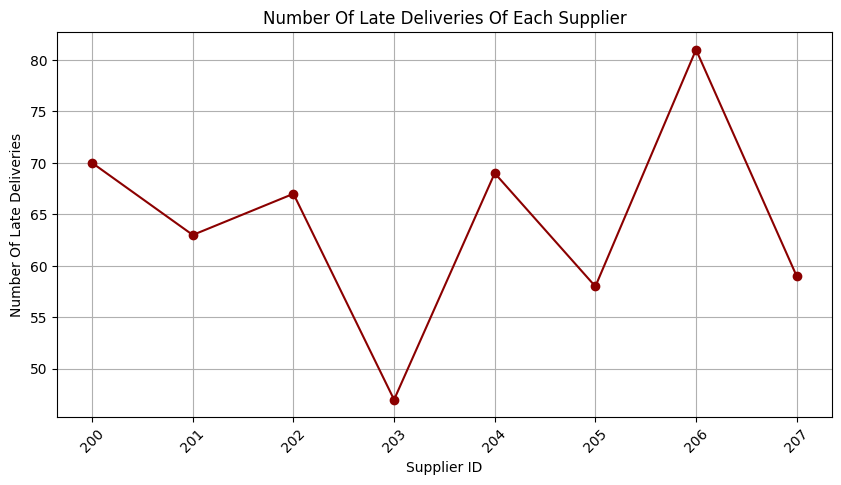

In [38]:
plt.figure(figsize=(10,5))
plt.plot(late_deliveries_df['supplier_id'], late_deliveries_df['LateDeliveries'] ,marker='o', color = 'darkred')
plt.grid()
plt.xticks(rotation=45)
plt.title('Number Of Late Deliveries Of Each Supplier')
plt.xlabel('Supplier ID')
plt.ylabel('Number Of Late Deliveries')
plt.show()

In [39]:
query8 = "select * from PrescriptionDemandWeekly;"
prescription_demand_weekly_df = pd.read_sql_query(query8,engine)

In [40]:
prescription_demand_weekly_df['SumDemandPrevWeek'] = prescription_demand_weekly_df['SumDemandPrevWeek'].fillna(0).astype(int)

In [41]:
prescription_demand_weekly_df['ChangeOverPrevWeek']  = prescription_demand_weekly_df['ChangeOverPrevWeek'].fillna(0)

In [42]:
prescription_demand_weekly_df.head(n=10)

,id,medicine_id,SumDemandPrevWeek,SumDemandCurrWeek,ChangeOverPrevWeek,WeekNum
0,1,100,0,11,0.00,0
1,2,100,11,16,45.45,1
2,3,100,16,43,168.75,2
3,4,100,43,17,-60.47,3
4,5,100,17,15,-11.76,4
5,6,100,15,17,13.33,5
6,7,100,17,19,11.76,6
7,8,100,19,17,-10.53,7
8,9,100,17,63,270.59,8
9,10,100,63,36,-42.86,9


In [43]:
def demand_weekly_trends(prescription_demand_weekly_df, medicine_id):
    demand_trends_data = prescription_demand_weekly_df[prescription_demand_weekly_df['medicine_id'] == medicine_id]

    sns.lineplot(x = 'WeekNum', y = 'ChangeOverPrevWeek', data = demand_trends_data, label = 'Demand Change Over Previous Week', color = 'darkblue', marker='o')
    plt.title(f'Medicine {medicine_id} - Demand Weekly Trends')
    plt.xlabel('Week Number')
    plt.ylabel('Number Of Medicines Prescibed')
    plt.grid()
    plt.show()

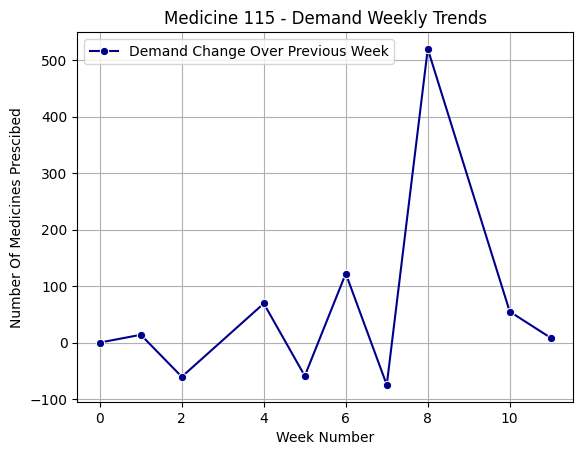

In [44]:
demand_weekly_trends(prescription_demand_weekly_df, medicine_id=115)

In [45]:
query9 = "select * from supply_trends_weekly;"
supply_trends_weekly_df = pd.read_sql_query(query9,engine)

In [46]:
supply_trends_weekly_df.head()

,id,medicine_id,SumQuantityPrevWeek,SumQuantityCurrWeek,ChangeOverPrevWeek,WeekNum
0,1,100,NaN,48,NaN,0
1,2,100,48.0,11,-77.08,1
2,3,100,11.0,12,9.09,3
3,4,100,12.0,10,-16.67,4
4,5,100,10.0,27,170.00,5


In [47]:
supply_trends_weekly_df['SumQuantityPrevWeek'] = supply_trends_weekly_df['SumQuantityPrevWeek'].fillna(0).astype(int)

In [48]:
supply_trends_weekly_df['ChangeOverPrevWeek'] = supply_trends_weekly_df['ChangeOverPrevWeek'].fillna(0)

In [49]:
def supply_weekly_trends(supply_trends_weekly_df, medicine_id):
    supply_trends_data = supply_trends_weekly_df[supply_trends_weekly_df['medicine_id'] == medicine_id]

    sns.lineplot(x = 'WeekNum', y = 'ChangeOverPrevWeek', data = supply_trends_data, label = 'Supply Change Over Previous Week', color = 'darkgreen', marker='o')
    plt.title(f'Medicine {medicine_id} - Supply Weekly Trends')
    plt.xlabel('Week Number')
    plt.ylabel('Number Of Medicines Supplied')
    plt.grid()
    plt.show()

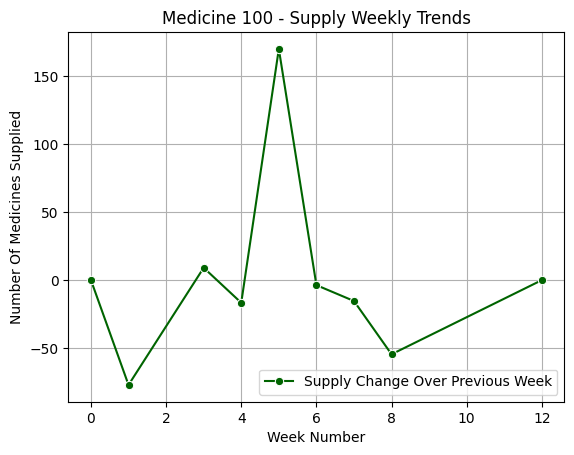

In [50]:
supply_weekly_trends(supply_trends_weekly_df,medicine_id=100)

In [51]:
query10 = "select * from OnTimeDeliveriesByEachSupplier;"
ontime_deliveries_df = pd.read_sql_query(query10,engine)

In [52]:
ontime_deliveries_df

,SupplierName,NumberOfOnTimeDelivery,TotalDeliveries,OnTimeDeliveryAsPercentageOfTotal
0,MediSupply Co.,22,118,18.64
1,Global Pharma Distributors,16,124,12.90
2,HealthBridge Suppliers,16,127,12.60
3,Evergreen Medical Supplies,8,102,7.84
4,Pioneer Drug Distributors,17,129,13.18
5,Elite Pharma Solutions,21,120,17.50
6,WellnessMed Supplies,17,145,11.72
7,Guardian Healthcare Logistics,25,135,18.52


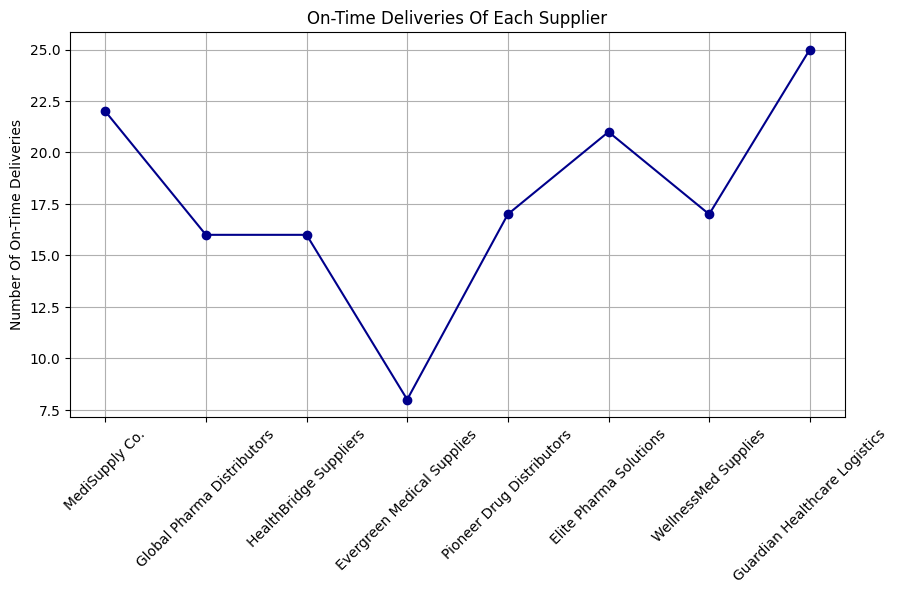

In [53]:
plt.figure(figsize=(10,5))
plt.plot(ontime_deliveries_df['SupplierName'], ontime_deliveries_df['NumberOfOnTimeDelivery'] ,marker='o', color = 'darkblue')
plt.grid()
plt.xticks(rotation=45)
plt.title('On-Time Deliveries Of Each Supplier')
plt.ylabel('Number Of On-Time Deliveries')
plt.show()

# Predicting Future Medicine Demands Using Linear Regression

In [54]:
prescription_demand_df.head()

,prescription_id,facility_id,medicine_id,quantity_prescribed,prescription_date,selling_price,revenue,payment_mode,insurance_covered_amount,patient_paid_amount
0,1,9,148,14,2024-03-28,113.53,1589.42,Insurance,1133.13,456.29
1,2,6,141,7,2024-01-29,85.44,598.08,Insurance,388.27,209.81
2,3,6,114,10,2024-02-23,41.84,418.40,Cash,0.00,209.20
3,4,6,123,12,2024-03-15,32.67,392.04,Cash,0.00,163.35
4,5,5,129,7,2024-03-01,48.51,339.57,Insurance,206.18,133.39


In [55]:
prescription_demand_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1950 entries, 0 to 1949
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   prescription_id           1950 non-null   int64  
 1   facility_id               1950 non-null   int64  
 2   medicine_id               1950 non-null   int64  
 3   quantity_prescribed       1950 non-null   int64  
 4   prescription_date         1950 non-null   object 
 5   selling_price             1950 non-null   float64
 6   revenue                   1950 non-null   float64
 7   payment_mode              1950 non-null   object 
 8   insurance_covered_amount  1950 non-null   float64
 9   patient_paid_amount       1950 non-null   float64
dtypes: float64(4), int64(4), object(2)
memory usage: 152.5+ KB


        Date  Predicted_Demand
0 2024-04-30            6889.0
1 2024-05-31            7232.5
2 2024-06-30            7576.0


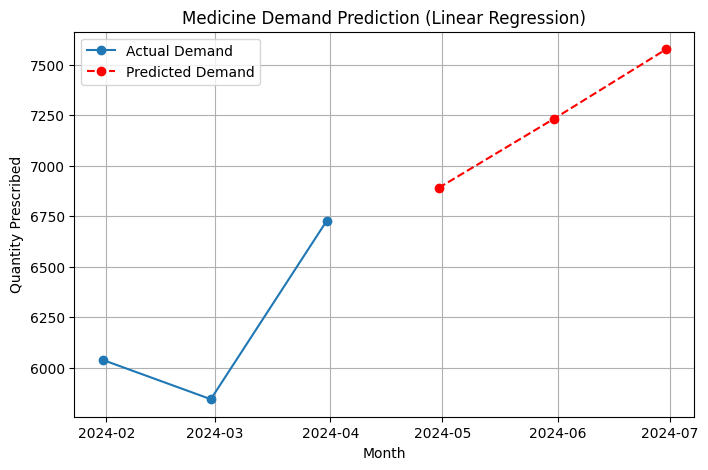

In [56]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Converting the prescription_date to datetime
prescription_demand_df['prescription_date'] = pd.to_datetime(prescription_demand_df['prescription_date'])
prescription_demand_df.set_index('prescription_date', inplace=True)


# Aggregate demand by month
monthly_demand = prescription_demand_df.resample('ME').sum()         # ------ only works if the date column is already the index


#monthly_demand = prescription_demand_df.groupby(pd.Grouper(freq='ME'),'facility_id').sum()    #works when the data column is not the index. Here, 'ME' is for the month                  


# Preparing data for Linear Regression
monthly_demand['month'] = monthly_demand.index.month      #  Extracting month number

X = monthly_demand[['month']]              # Feature: month number
y = monthly_demand['quantity_prescribed']  # Target: demand

# Training the Linear Regression Model
model = LinearRegression()
model.fit(X, y)

# Predicting for the next 3 months
future_months = pd.DataFrame({'month': [4, 5, 6]})        # Match the training column name
#future_months = np.array([[4], [5], [6]])                # We have to adjust it based on the last month
predictions = model.predict(future_months)

# Creating a dataFrame for future predictions
future_dates = pd.date_range(start=monthly_demand.index[-1] + pd.DateOffset(months=1), periods=3, freq='ME')
predicted_df = pd.DataFrame({'Date': future_dates, 'Predicted_Demand': predictions})

print(predicted_df)

plt.figure(figsize=(8, 5))
plt.plot(monthly_demand.index, monthly_demand['quantity_prescribed'], marker='o', label="Actual Demand")
plt.plot(predicted_df['Date'], predicted_df['Predicted_Demand'], marker='o', linestyle="dashed", color='red', label="Predicted Demand")
plt.xlabel("Month")
plt.ylabel("Quantity Prescribed")
plt.title("Medicine Demand Prediction (Linear Regression)")
plt.legend()
plt.grid()
plt.show()

In [57]:
current_demand_df = prescription_demand_df.groupby(pd.Grouper(freq='ME'))['quantity_prescribed'].sum().reset_index()
current_demand_df.columns = ['Date', 'Predicted_Demand']
current_demand_df['month'] = monthly_demand.index.month

In [58]:
#current_demand_df

In [59]:
predicted_df['month'] = predicted_df['Date'].dt.month

In [60]:
#predicted_df

In [61]:
predicted_demand_final_df = pd.concat([current_demand_df, predicted_df], ignore_index=True)

predicted_demand_final_df.sort_values(by='Date', inplace=True)

predicted_demand_final_df['Predicted_Demand'] = predicted_demand_final_df['Predicted_Demand'].astype(int)

predicted_demand_final_df

,Date,Predicted_Demand,month
0,2024-01-31,6038,1
1,2024-02-29,5843,2
2,2024-03-31,6725,3
3,2024-04-30,6889,4
4,2024-05-31,7232,5
5,2024-06-30,7576,6


# Predicting Future Medicine Demands for each facility using linear regression - 

    facility_id       Date  Predicted_Demand
0             1 2024-04-30               767
1             1 2024-05-31               858
2             1 2024-06-30               949
3             2 2024-04-30               809
4             2 2024-05-31               871
5             2 2024-06-30               933
6             3 2024-04-30               790
7             3 2024-05-31               836
8             3 2024-06-30               881
9             4 2024-04-30               591
10            4 2024-05-31               597
11            4 2024-06-30               604
12            5 2024-04-30               359
13            5 2024-05-31               273
14            5 2024-06-30               186
15            6 2024-04-30               695
16            6 2024-05-31               750
17            6 2024-06-30               806
18            7 2024-04-30               594
19            7 2024-05-31               569
20            7 2024-06-30               543
21        

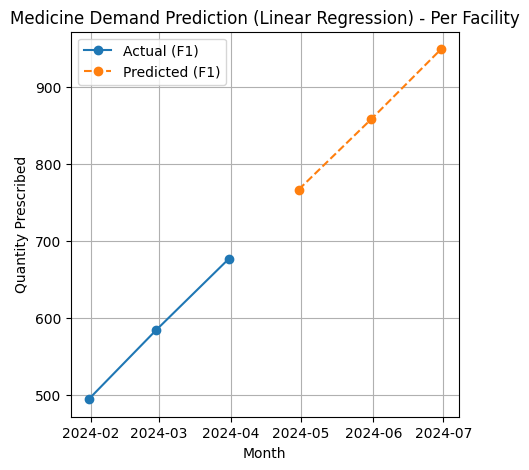

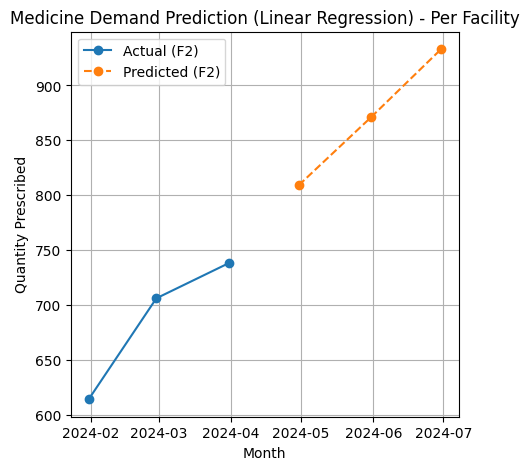

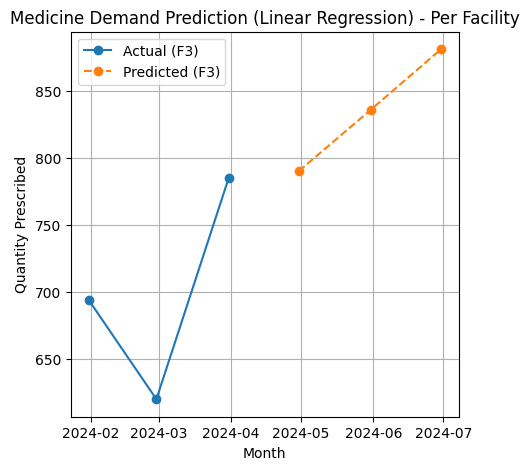

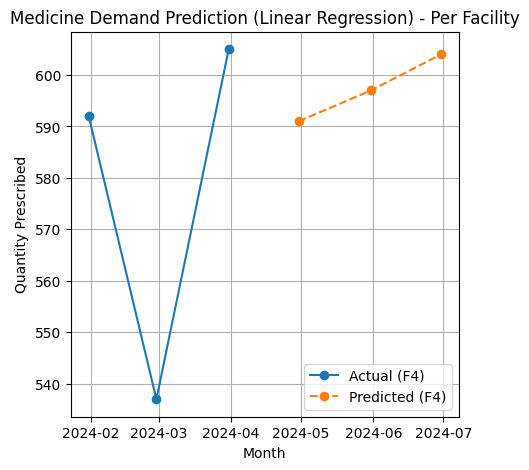

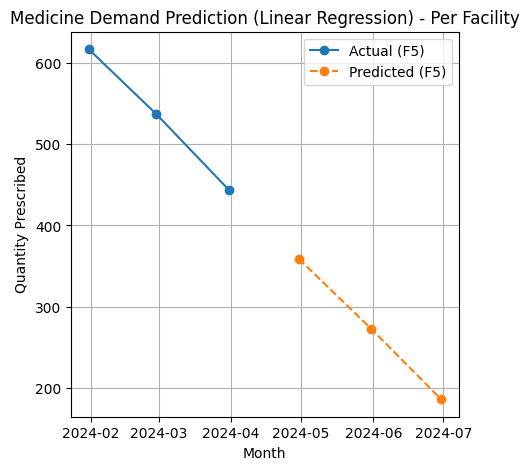

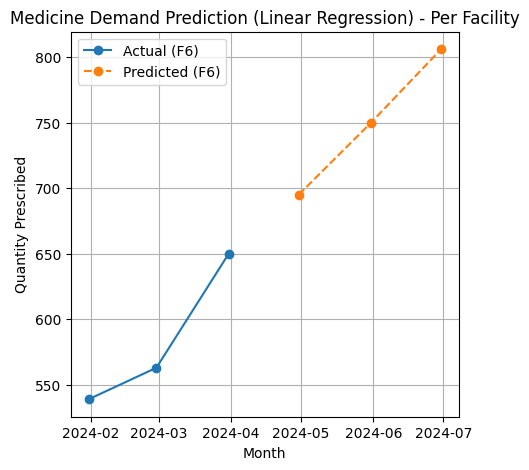

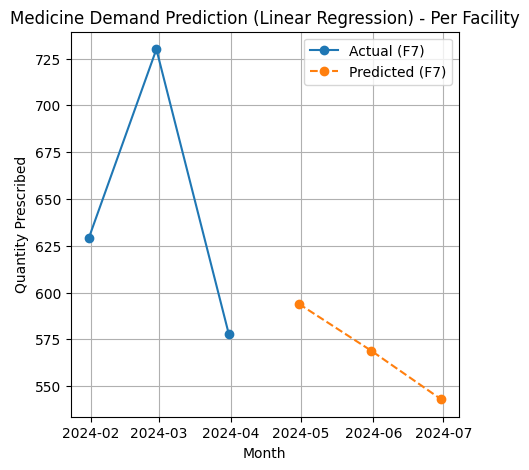

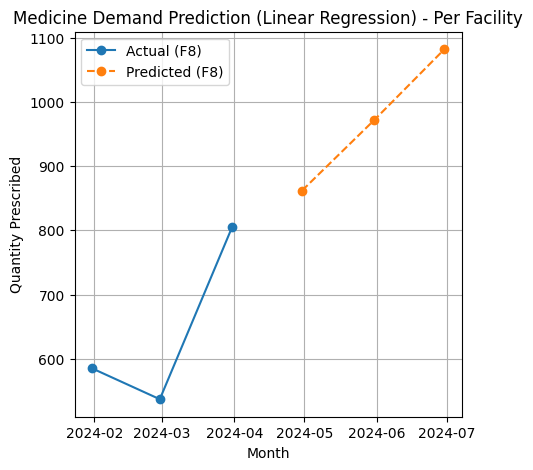

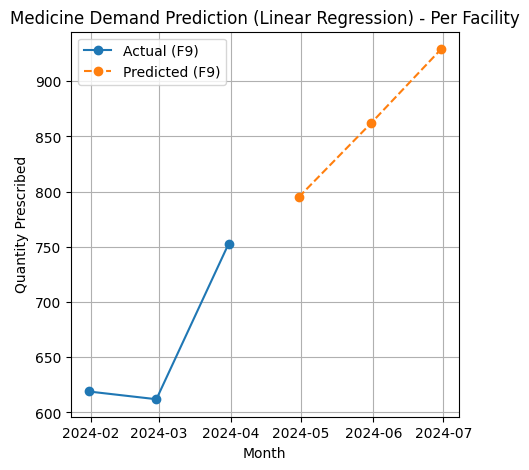

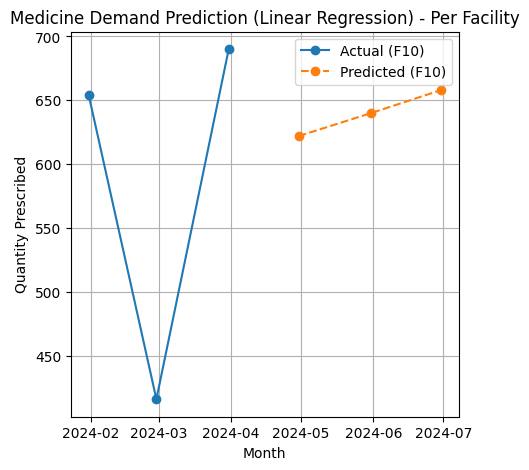

In [62]:
# Aggregate demand by facility and month
monthly_demand = prescription_demand_df.groupby(['facility_id', pd.Grouper(freq='ME')])['quantity_prescribed'].sum().reset_index()

# Extract month from the date
monthly_demand['month'] = monthly_demand['prescription_date'].dt.month

# DataFrame to store predictions
all_predictions = []

# Train and predict separately for each facility
facilities = monthly_demand['facility_id'].unique()
for facility in facilities:
    facility_data = monthly_demand[monthly_demand['facility_id'] == facility]

    X = facility_data[['month']]  # Feature: month number
    y = facility_data['quantity_prescribed']  # Target: demand

    if len(facility_data) < 2:  # we are going to skip if there's not enough data to train the model
        continue

    # Train the Linear Regression model
    model = LinearRegression()
    model.fit(X, y)

    # Predict for the next 3 months
    last_date = facility_data['prescription_date'].max()
    future_months = pd.DataFrame({'month': [(last_date + pd.DateOffset(months=i)).month for i in range(1, 4)]})

    predictions = model.predict(future_months)

    # Store results in a DataFrame
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=3, freq='ME')
    predicted_df = pd.DataFrame({'facility_id': facility, 'Date': future_dates, 'Predicted_Demand': predictions})

    all_predictions.append(predicted_df)

# Combine predictions from all facilities
final_predictions = pd.concat(all_predictions, ignore_index=True)

final_predictions['Predicted_Demand'] = final_predictions['Predicted_Demand'].astype(int)

# Print final predictions
print(final_predictions)


for facility in facilities:
    plt.figure(figsize = (5,5))
    facility_data = monthly_demand[monthly_demand['facility_id'] == facility]
    plt.plot(facility_data['prescription_date'], facility_data['quantity_prescribed'], marker='o', label=f"Actual (F{facility})")

    facility_pred = final_predictions[final_predictions['facility_id'] == facility]
    plt.plot(facility_pred['Date'], facility_pred['Predicted_Demand'], marker='o', linestyle="dashed", label=f"Predicted (F{facility})")

    plt.xlabel("Month")
    plt.ylabel("Quantity Prescribed")
    plt.title("Medicine Demand Prediction (Linear Regression) - Per Facility")
    plt.legend()
    plt.grid()
    plt.show()

In [63]:
final_predictions.head()

,facility_id,Date,Predicted_Demand
0,1,2024-04-30,767
1,1,2024-05-31,858
2,1,2024-06-30,949
3,2,2024-04-30,809
4,2,2024-05-31,871


In [64]:
monthly_demand.head()

,facility_id,prescription_date,quantity_prescribed,month
0,1,2024-01-31,495,1
1,1,2024-02-29,585,2
2,1,2024-03-31,677,3
3,2,2024-01-31,614,1
4,2,2024-02-29,706,2


In [65]:
combined_final = pd.concat([final_predictions, monthly_demand], axis = 1)

In [66]:
combined_final = combined_final.loc[:, ~combined_final.columns.duplicated()]
combined_final.drop(columns = ['month'], inplace=True)

In [67]:
combined_final['Date'] = combined_final['Date'].dt.month
combined_final['prescription_date'] = combined_final['prescription_date'].dt.month
combined_final = combined_final.rename(columns = {'Date' : 'forecasted_month', 'prescription_date' : 'prescription_month'})

In [68]:
combined_final.head()

,facility_id,forecasted_month,Predicted_Demand,prescription_month,quantity_prescribed
0,1,4,767,1,495
1,1,5,858,2,585
2,1,6,949,3,677
3,2,4,809,1,614
4,2,5,871,2,706


combined_final.to_sql('forecasted_actual_demand', con=engine, if_exists='fail', index=False,
          dtype={
              'facility_id': Integer(),
              'forecasted_month': Integer(),
              'Predicted_Demand': Integer(),
              'prescription_month': Integer(),
              'quantity_prescribed': Integer()
          })

# Average Delay Days Of Suppliers

In [69]:
supply_orders_df.head()

,order_id,supplier_id,medicine_id,facility_id,quantity_ordered,order_date,expected_delivery_date,actual_delivery_date
0,1,207,107,9,14,2024-03-24,2024-03-29,2024-03-31
1,2,205,122,7,14,2024-03-10,2024-03-20,2024-03-20
2,3,202,107,6,12,2024-02-28,2024-03-09,2024-03-11
3,4,202,135,3,10,2024-03-10,2024-03-14,2024-03-13
4,5,206,142,5,13,2024-03-22,2024-03-27,2024-03-27


In [70]:
#supply_orders_df.drop(columns = ['delay_days'], inplace=True)

In [71]:
supply_orders_df['delay_days'] = (supply_orders_df['actual_delivery_date'] - supply_orders_df['expected_delivery_date']).dt.days
supplier_delays = supply_orders_df[supply_orders_df['delay_days'] > 0].groupby('supplier_id')['delay_days'].mean().reset_index()
supplier_delays.columns = ['Supplier ID', 'Average Delay Days']
#supplier_delays

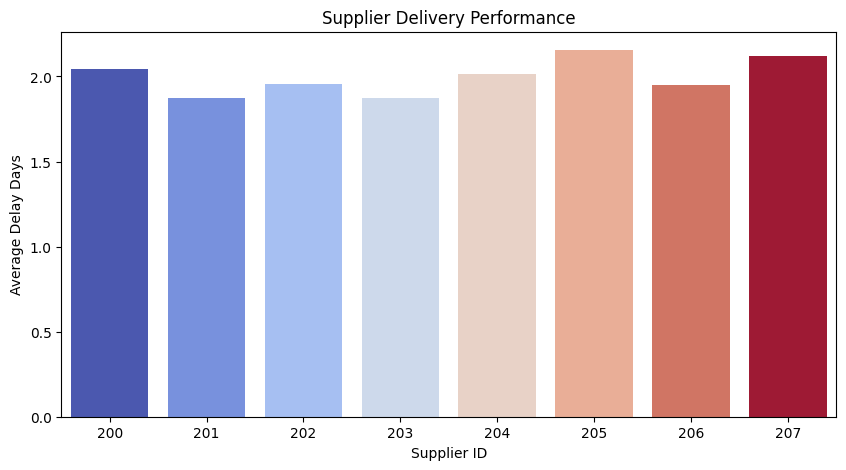

In [72]:
plt.figure(figsize=(10, 5))
sns.barplot(x='Supplier ID', y='Average Delay Days', data=supplier_delays, hue='Supplier ID', dodge=False, legend=False, palette="coolwarm")
plt.xlabel("Supplier ID")
plt.ylabel("Average Delay Days")
plt.title("Supplier Delivery Performance")
plt.show()

# Top 10 Medicines By Revenue

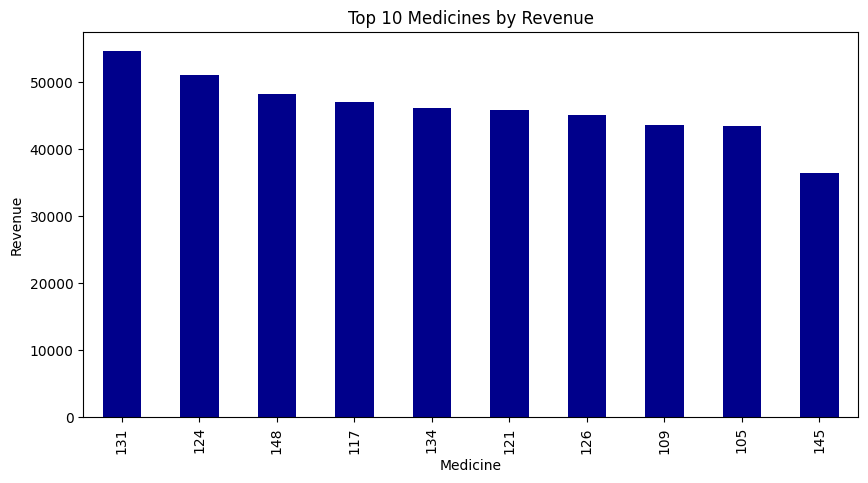

In [73]:
top_medicines = prescription_demand_df.groupby('medicine_id')['revenue'].sum().nlargest(10)      #.reset_index()
#top_medicines.columns = ['Medicine ID', 'Revenue']
#print(top_medicines)

plt.figure(figsize=(10,5))
#sns.barplot(x="Medicine ID", y="Revenue",data=top_medicines)
top_medicines.plot(kind='bar', color='darkblue')
plt.title("Top 10 Medicines by Revenue")
plt.xlabel("Medicine")
plt.ylabel("Revenue")
plt.xticks(rotation=90)
plt.show()

# Outlier Detection For Medicines Selling Price

In [74]:
from scipy.stats import zscore

In [75]:
medicines_df['price_zscore'] = zscore(medicines_df['selling_price'])
outliers = medicines_df[medicines_df['price_zscore'].abs() > 3]  # Z-score > 3
print(outliers)

Empty DataFrame
Columns: [medicine_id, name, category, manufacturer, shelf_life, cost_price, selling_price, profit_margin, price_zscore]
Index: []


<Axes: xlabel='selling_price'>

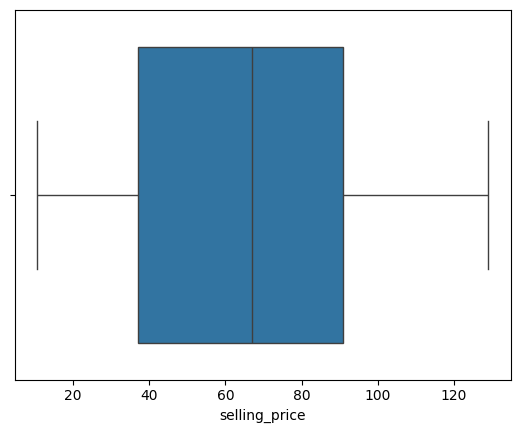

In [76]:
sns.boxplot(x=medicines_df['selling_price'])

# Demand vs Supply Gap Analysis For Each Medicine

In [77]:
supply_orders_df['month'] = supply_orders_df['order_date'].dt.month

In [78]:
#quantity_ordered_monthly[('Quantity Ordered','Jan')]
#quantity_ordered_monthly.loc[:, ('Quantity Ordered', ['Jan','Feb'])]

#quantity_ordered_monthly

In [79]:
prescription_demand_df['month'] = prescription_demand_df.index.month

In [80]:
def get_facility_data(facility_id = None):

    if facility_id is not None:
        supply_filtered = supply_orders_df[supply_orders_df['facility_id'] == facility_id]
        demand_filtered = prescription_demand_df[prescription_demand_df['facility_id'] == facility_id]
    else:
        supply_filtered = supply_orders_df  # Use all data
        demand_filtered = prescription_demand_df 

    # aggregate and pivot quantity ordered
    quantity_ordered_monthly = supply_filtered.groupby(['medicine_id', 'month'])['quantity_ordered'].sum().unstack(fill_value=0)

    # aggregate and pivot quantity prescribed
    quantity_prescribed_monthly = demand_filtered.groupby(['medicine_id', 'month'])['quantity_prescribed'].sum().unstack(fill_value=0)

    # ensure both the dataFrames have the same structure (index & columns)
    quantity_prescribed_monthly, quantity_ordered_monthly = quantity_prescribed_monthly.align(
        quantity_ordered_monthly, fill_value=0
    )

    shortage_monthly = quantity_prescribed_monthly - quantity_ordered_monthly

    # dynamically assigning multiIndex column names
    quantity_ordered_monthly.columns = pd.MultiIndex.from_tuples(
        [('Quantity Ordered', month) for month in ['Jan', 'Feb', 'Mar']]
    )

    quantity_prescribed_monthly.columns = pd.MultiIndex.from_tuples(
        [('Quantity Prescribed', month) for month in ['Jan', 'Feb', 'Mar']]
    )

    shortage_monthly.columns = pd.MultiIndex.from_tuples(
        [('Shortage', month) for month in ['Jan', 'Feb', 'Mar']]
    )

    combined_df = pd.concat([quantity_prescribed_monthly, quantity_ordered_monthly, shortage_monthly], axis=1)

    return combined_df


facility_id = None
facility_data = get_facility_data(facility_id)

facility_data


Quantity Prescribed           Quantity Ordered           Shortage  \
                            Jan  Feb  Mar              Jan  Feb  Mar      Jan   
medicine_id                                                                     
100                         102  106  232               81   85   10       21   
101                         114  155   92               75   75  149       39   
102                         118  148   70               61   97   77       57   
103                          69  124  129               49   12   61       20   
104                         110   34  156              110   89   60        0   
105                         136  120  164              102   69   53       34   
106                         126   86  221              100   46   99       26   
107                         158  146  176               50   54   85      108   
108                          69  121  112               66   68   57        3   
109                         168  114  109               63  102   90      105   
110                         106   80  106               60  121  102       46   
111                         126  133  162               96   92   63       30   
112                         221  136  144              111  148   78      110   
113                         101  129  119               55  101   89       46   
114                         162   89  133               84   46   61       78   
115                          86   76  100              154   71   38      -68   
116                         135   79  133               68   98   57       67   
117                          79  122  164               44   93   92       35   
118                         143   99  113              137   76   66        6   
119                         133  149   69               68   46   94       65   
120                         188  115   92              121   74   67       67   
121                         104  151  182              101   73  128        3   
122                          91  146  164              116   52  113      -25   
123                          93  148  100               64   95   51       29   
124                         135  124  197              142   74   68       -7   
125                         164   91   80              105   75   93       59   
126                         160  127  129               69   55   91       91   
127                         130  151  100              135   86  137       -5   
128                         197  105  139               68   78  138      129   
129                          85  135  147               74   90   64       11   
130                         120  148   61               71  125   71       49   
131                         145  163  160               82  108   46       63   
132                          59  111  142               90  111   89      -31   
133                          52   68  124               89   22  108      -37   
134                         146   99  119               75   47   74       71   
135                         172   58  194               96   13  104       76   
136                         127  126  156              109   79   70       18   
137                          48   79  114               61   65   47      -13   
138                          91  111  155               90   37  111        1   
139                         130   75   90               83   52   62       47   
140                          66  122  132              127   59   92      -61   
141                          76  138  123               92   83   44      -16   
142                         133   86  178               90  119  112       43   
143                         160  162  128               59   52   74      101   
144                         165  196  122               26   80   90      139   
145                         123   83  115               44   92   44       79   
146                         116  102  115  

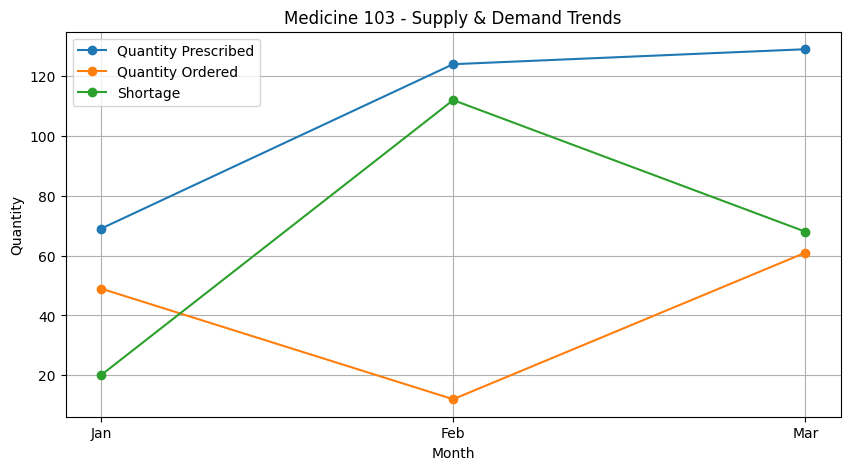

In [81]:
def plot_medicine_trends(medicine_id, df):
    if medicine_id not in df.index:
        print(f"Medicine ID {medicine_id} not found in the data")
        return
    
    data = df.loc[medicine_id]  # Getting the data for the specified medicine 
    
    plt.figure(figsize=(10, 5))
    
    for category in ['Quantity Prescribed', 'Quantity Ordered', 'Shortage']:
        plt.plot(data[category].index, data[category].values, marker='o', label=category)

    plt.xlabel("Month")
    plt.ylabel("Quantity")
    plt.title(f"Medicine {medicine_id} - Supply & Demand Trends")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_medicine_trends(medicine_id=103, df=get_facility_data())

# Predictive Stockout Analysis

In [82]:
prescription_demand_df = prescription_demand_df.reset_index()

In [83]:
prescription_demand_df['daily_demand'] = (
    prescription_demand_df.groupby(['facility_id', 'medicine_id'])['quantity_prescribed'].transform('sum') /
    prescription_demand_df.groupby(['facility_id', 'medicine_id'])['prescription_date'].transform('nunique')
)

In [84]:
prescription_demand_df['daily_demand'] = prescription_demand_df['daily_demand'].astype(int)

In [85]:
#prescription_demand_df.count()

In [86]:
inventory_df.head(n=30)

,inventory_id,facility_id,medicine_id,cost_price,quantity_in_stock,reorder_level,inventory_value,expiry_date,last_updated,NeedsRestocking
0,1,1,100,61.49,45,0,2767.05,2025-07-15,2025-02-14,No
1,2,1,101,16.07,42,105,674.94,2027-08-13,2025-02-14,Yes
2,3,1,102,51.96,40,69,2078.40,2025-10-18,2025-02-14,Yes
3,4,1,103,73.96,38,46,2810.48,2027-05-20,2025-02-14,Yes
4,5,1,104,64.37,38,88,2446.06,2026-04-14,2025-02-14,Yes
5,6,1,105,84.35,42,71,3542.70,2028-02-29,2025-02-14,Yes
6,7,1,106,34.65,62,40,2148.30,2026-11-05,2025-02-14,No
7,8,1,107,32.88,59,52,1939.92,2027-02-19,2025-02-14,No
8,9,1,108,10.22,45,69,459.90,2025-12-19,2025-02-14,Yes
9,10,1,109,96.59,42,81,4056.78,2025-10-09,2025-02-14,Yes


In [87]:
inventory_df = inventory_df.merge(
    prescription_demand_df[['facility_id', 'medicine_id', 'daily_demand']].drop_duplicates(subset = ['facility_id', 'medicine_id'], keep = 'first'),
    on=['facility_id', 'medicine_id'],
    how='left'  # we use 'left' to keep all prescription records, even if no matching inventory
)

In [88]:
inventory_df['daily_demand'] = inventory_df['daily_demand'].fillna(0).astype(int)

In [89]:
inventory_df['days_until_stockout'] = inventory_df['quantity_in_stock'] / inventory_df['daily_demand']

In [90]:
inventory_df['days_until_stockout'] = pd.to_numeric(inventory_df['days_until_stockout'], errors='coerce')

In [91]:
inventory_df['days_until_stockout'] = inventory_df['days_until_stockout'].replace([float('inf'), float('-inf')], 0)

In [92]:
inventory_df['days_until_stockout'] = inventory_df['days_until_stockout'].astype(int)

In [93]:
print(inventory_df['days_until_stockout'].dtype)

int64


In [94]:
inventory_df[inventory_df['medicine_id'] == 131]

,inventory_id,facility_id,medicine_id,cost_price,quantity_in_stock,reorder_level,inventory_value,expiry_date,last_updated,NeedsRestocking,daily_demand,days_until_stockout
31,32,1,131,92.29,64,74,5906.56,2026-10-31,2025-02-14,Yes,11,5
81,82,2,131,92.29,50,0,4614.50,2026-03-12,2025-02-14,No,9,5
131,132,3,131,92.29,41,66,3783.89,2025-10-27,2025-02-14,Yes,9,4
181,182,4,131,92.29,41,48,3783.89,2025-09-23,2025-02-14,Yes,9,4
231,232,5,131,92.29,43,108,3968.47,2025-06-29,2025-02-14,Yes,11,3
281,282,6,131,92.29,52,61,4799.08,2025-06-14,2025-02-14,Yes,10,5
331,332,7,131,92.29,36,55,3322.44,2025-05-19,2025-02-14,Yes,11,3
381,382,8,131,92.29,40,53,3691.60,2026-01-12,2025-02-14,Yes,11,3
431,432,9,131,92.29,48,97,4429.92,2025-04-30,2025-02-14,Yes,11,4
481,482,10,131,92.29,52,64,4799.08,2027-04-21,2025-02-14,Yes,10,5


# Supplier Performance Trend Monthly

In [95]:
supply_orders_df.head()

,order_id,supplier_id,medicine_id,facility_id,quantity_ordered,order_date,expected_delivery_date,actual_delivery_date,delay_days,month
0,1,207,107,9,14,2024-03-24,2024-03-29,2024-03-31,2,3
1,2,205,122,7,14,2024-03-10,2024-03-20,2024-03-20,0,3
2,3,202,107,6,12,2024-02-28,2024-03-09,2024-03-11,2,2
3,4,202,135,3,10,2024-03-10,2024-03-14,2024-03-13,-1,3
4,5,206,142,5,13,2024-03-22,2024-03-27,2024-03-27,0,3


In [96]:
supplier_performance = supply_orders_df[supply_orders_df['delay_days'] > 0].groupby([supply_orders_df['actual_delivery_date'].dt.to_period('M'),'supplier_id'])['delay_days'].mean().reset_index()

In [97]:
supplier_performance['actual_delivery_date'] = supplier_performance['actual_delivery_date'].astype(str)

In [98]:
supplier_performance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   actual_delivery_date  32 non-null     object 
 1   supplier_id           32 non-null     int64  
 2   delay_days            32 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 900.0+ bytes


In [99]:
def plot_supplier_trend(supplier_performance, supplier_id):
    supplier_data = supplier_performance[supplier_performance['supplier_id'] == supplier_id]
    sns.lineplot(x='actual_delivery_date', y='delay_days', data = supplier_data, marker = 'o')
    plt.xlabel("Month")
    plt.ylabel("Average Delay (days)")
    plt.title(f"Supplier {supplier_id} - Delivery Delay Trend")
    plt.grid(True)
    plt.show()

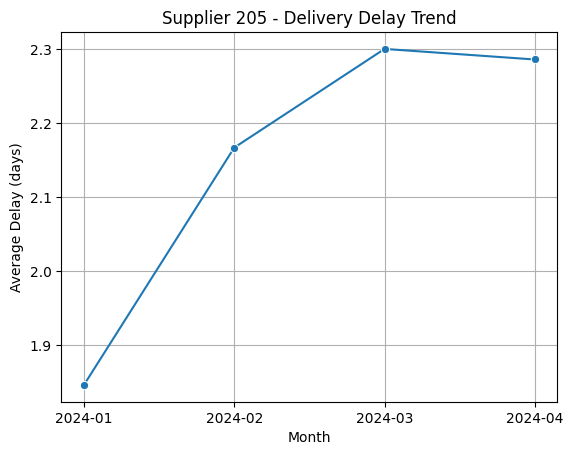

In [100]:
plot_supplier_trend(supplier_performance,supplier_id=205)

In [101]:
#prescription_demand_df.groupby(prescription_demand_df['prescription_date'].dt.to_period('M'))['quantity_prescribed'].sum().plot(kind='line')  

In [102]:
#supply_orders_df.pivot_table(index='supplier_id', values='quantity_ordered', aggfunc='mean')  

In [103]:
#supply_orders_df.groupby(supply_orders_df['order_date'].dt.weekday)['quantity_ordered'].mean().plot(kind='bar')  

from sqlalchemy.types import Integer, Float, String, DateTime

prescription_demand_df.to_sql('prescription_data_new', con=engine, if_exists='fail', index=False, 
          dtype={ 
              'prescription_date': DateTime(),  
              'prescription_id': Integer(),  
              'facility_id': Integer(),
              'medicine_id': Integer(),
              'quantity_prescribed': Integer(),
              'selling_price': Float(),
              'revenue': Float(),
              'payment_mode': String(50),
              'insurance_covered_amount': Float(),
              'patient_paid_amount': Float(),
              'month': Integer(),
              'daily_demand': Integer()
          })


supply_orders_df.to_sql('supply_orders_new', con=engine, if_exists='fail', index=False,
          dtype={
              'order_id': Integer(),
              'supplier_id': Integer(),
              'medicine_id': Integer(),
              'facility_id': Integer(),
              'quantity_ordered': Integer(),
              'order_date': DateTime(),
              'expected_delivery_date': DateTime(),
              'actual_delivery_date': DateTime(),
              'delay_days': Integer(),
              'month': Integer()
          })

In [106]:
facility_data.head()

Quantity Prescribed           Quantity Ordered          Shortage  \
                            Jan  Feb  Mar              Jan Feb  Mar      Jan   
medicine_id                                                                    
100                         102  106  232               81  85   10       21   
101                         114  155   92               75  75  149       39   
102                         118  148   70               61  97   77       57   
103                          69  124  129               49  12   61       20   
104                         110   34  156              110  89   60        0   

                       
             Feb  Mar  
medicine_id            
100           21  222  
101           80  -57  
102           51   -7  
103          112   68  
104          -55   96

In [107]:
facility_data.columns

MultiIndex([('Quantity Prescribed', 'Jan'),
            ('Quantity Prescribed', 'Feb'),
            ('Quantity Prescribed', 'Mar'),
            (   'Quantity Ordered', 'Jan'),
            (   'Quantity Ordered', 'Feb'),
            (   'Quantity Ordered', 'Mar'),
            (           'Shortage', 'Jan'),
            (           'Shortage', 'Feb'),
            (           'Shortage', 'Mar')],
           )

In [108]:
facility_data = facility_data.reset_index()

In [109]:
# Flatten MultiIndex column names
#facility_data.columns = ["_".join(col) for col in facility_data.columns]

In [110]:
#facility_data.to_sql('facility_wise_shortage', con=engine, if_exists='fail', index=False,
 #         dtype= {col : Integer() for col in facility_data.columns})

# Forecasting Reorder Levels -

In [111]:
inventory_df.head()

,inventory_id,facility_id,medicine_id,cost_price,quantity_in_stock,reorder_level,inventory_value,expiry_date,last_updated,NeedsRestocking,daily_demand,days_until_stockout
0,1,1,100,61.49,45,0,2767.05,2025-07-15,2025-02-14,No,10,4
1,2,1,101,16.07,42,105,674.94,2027-08-13,2025-02-14,Yes,12,3
2,3,1,102,51.96,40,69,2078.40,2025-10-18,2025-02-14,Yes,8,5
3,4,1,103,73.96,38,46,2810.48,2027-05-20,2025-02-14,Yes,10,3
4,5,1,104,64.37,38,88,2446.06,2026-04-14,2025-02-14,Yes,12,3


In [112]:
supply_orders_df['days_to_deliver'] = (supply_orders_df['actual_delivery_date'] - supply_orders_df['order_date']).dt.days

In [113]:
#supply_orders_df.head()

In [114]:
lead_time = supply_orders_df.groupby(['facility_id','medicine_id'])['days_to_deliver'].mean().reset_index()
lead_time.columns = ['facility_id', 'medicine_id', 'average_days_to_deliver']
lead_time['average_days_to_deliver'] = lead_time['average_days_to_deliver'].astype(int)

In [115]:
#lead_time.head()

In [116]:
inventory_df = inventory_df.merge(lead_time[['facility_id', 'medicine_id', 'average_days_to_deliver']], 
                                  on = ['facility_id', 'medicine_id']
                                 ,how = 'left')

In [117]:
inventory_df['average_days_to_deliver'] = inventory_df['average_days_to_deliver'].fillna(0).astype(int)

In [118]:
from scipy.stats import norm

In [119]:
#Compute Safety Stock using Z-score (95% confidence level)

service_level = 0.95
z_score = norm.ppf(service_level)

In [120]:
daily_demand_df = prescription_demand_df.groupby(
    ['facility_id', 'medicine_id', 'prescription_date']
)['quantity_prescribed'].sum().reset_index()


demand_stats_df = daily_demand_df.groupby(['facility_id', 'medicine_id']).agg(
    avg_daily_demand=('quantity_prescribed', 'mean'),
    std_daily_demand=('quantity_prescribed', 'std')  # Std deviation of daily demand
).reset_index()


safety_stock_df = demand_stats_df.merge(
    inventory_df[['facility_id', 'medicine_id', 'average_days_to_deliver']].drop_duplicates(),
    on=['facility_id', 'medicine_id'],
    how='left'
)

In [121]:
#demand_stats_df.head(n=10)

In [122]:
safety_stock_df.head()

,facility_id,medicine_id,avg_daily_demand,std_daily_demand,average_days_to_deliver
0,1,100,10.571429,2.572751,0
1,1,101,12.000000,NaN,8
2,1,102,8.750000,3.593976,7
3,1,103,10.600000,2.607681,4
4,1,104,12.000000,1.632993,7


In [123]:
safety_stock_df['avg_daily_demand'] = safety_stock_df['avg_daily_demand'].astype(int)
safety_stock_df["std_daily_demand"] = safety_stock_df["std_daily_demand"].fillna(safety_stock_df["std_daily_demand"].median())
safety_stock_df['std_daily_demand'] = safety_stock_df['std_daily_demand'].astype(int)

In [124]:
safety_stock_df['safety_stock'] = z_score * safety_stock_df['std_daily_demand'] * np.sqrt(safety_stock_df['average_days_to_deliver'])

In [125]:
safety_stock_df['safety_stock'] = safety_stock_df['safety_stock'].fillna(0).astype(int)

In [126]:
safety_stock_df.head(n=10)

,facility_id,medicine_id,avg_daily_demand,std_daily_demand,average_days_to_deliver,safety_stock
0,1,100,10,2,0,0
1,1,101,12,2,8,9
2,1,102,8,3,7,13
3,1,103,10,2,4,6
4,1,104,12,1,7,4
5,1,105,9,2,7,8
6,1,106,10,0,4,0
7,1,107,9,2,5,7
8,1,108,8,3,7,13
9,1,109,8,2,9,9


In [127]:
inventory_df = inventory_df.merge(
    safety_stock_df[['facility_id', 'medicine_id', 'safety_stock']],
    on = ['facility_id','medicine_id'],
    how = 'left'
)

In [128]:
inventory_df['safety_stock'] = inventory_df['safety_stock'].fillna(0).astype(int)

In [129]:
inventory_df['reorder_level'] = (inventory_df['daily_demand'] * inventory_df['average_days_to_deliver']) + inventory_df['safety_stock']

In [130]:
inventory_df.head()

,inventory_id,facility_id,medicine_id,cost_price,quantity_in_stock,reorder_level,inventory_value,expiry_date,last_updated,NeedsRestocking,daily_demand,days_until_stockout,average_days_to_deliver,safety_stock
0,1,1,100,61.49,45,0,2767.05,2025-07-15,2025-02-14,No,10,4,0,0
1,2,1,101,16.07,42,105,674.94,2027-08-13,2025-02-14,Yes,12,3,8,9
2,3,1,102,51.96,40,69,2078.40,2025-10-18,2025-02-14,Yes,8,5,7,13
3,4,1,103,73.96,38,46,2810.48,2027-05-20,2025-02-14,Yes,10,3,4,6
4,5,1,104,64.37,38,88,2446.06,2026-04-14,2025-02-14,Yes,12,3,7,4


inventory_df.to_sql('inventory_data_new', con=engine, if_exists='fail', index=False,
          dtype={
              'inventory_id': Integer(),
              'facility_id': Integer(),
              'medicine_id': Integer(),
              'cost_price': Float(),
              'quantity_in_stock': Integer(),
              'reorder_level': Integer(),
              'inventory_value': Float(),
              'expiry_date': DateTime(),
              'last_updated': DateTime(),
              'NeedsRestocking': String(10),
               'daily_demand': Integer(),
              'days_until_stockout': Integer(),
              'average_days_to_deliver': Integer(),
              'safety_stock': Integer()
          })